In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Model
from keras.layers import concatenate, Dense, Input, Flatten
from keras.optimizers import Adam
import gym
from rl.agents import eventDDPGAgent
from rl.memory import SequentialMemory

Using TensorFlow backend.
/Users/admin/.pyenv/versions/3.6.6/lib/python3.6/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
# GymのPendulum環境を作成
env = gym.make("Pendulum-v0")

# 取りうる”打ち手”のアクション数と値の定義
nb_actions = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [3]:
def actor_net(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input)
    x = Dense(32, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(3, activation="tanh")(x)
    actor = Model(inputs=action_input, outputs=x)
    return actor

def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(32, activation="relu")(x)
    x = Dense(32, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

In [9]:
def agent(a_shape, s_shape):
    actor = actor_net(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = eventDDPGAgent(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        clip_com=0.01
    )
    return agent

Training for 150000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 48s 5ms/step - reward: -7.2776
50 episodes - episode_reward: -1455.511 [-1917.069, -856.932] - loss: 2.692 - mean_squared_error: 5.384 - mean_q: -32.165

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 55s 6ms/step - reward: -5.9885
50 episodes - episode_reward: -1197.700 [-1576.356, -362.581] - loss: 16.609 - mean_squared_error: 33.218 - mean_q: -83.377

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 56s 6ms/step - reward: -4.1447
50 episodes - episode_reward: -828.934 [-1391.535, -1.629] - loss: 35.860 - mean_squared_error: 71.719 - mean_q: -114.995

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 59s 6ms/step - reward: -2.7192
50 episodes - episode_reward: -543.831 [-1344.107, -0.416] - loss: 46.240 - mean_squared_error: 92.479 - mean_q: -127.978

Interval 5 (40000 steps perf

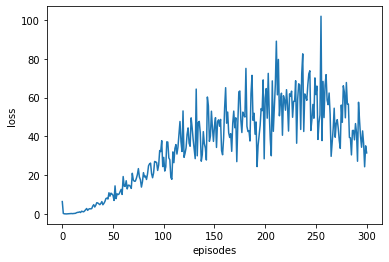

Finish Learning. We start test phase.


In [10]:
#通信によるコストの強さを設定
l = 0
agent = agent((3,), env.observation_space.shape) #agent((actor output dim),(state_dim))
agent.compile(Adam(lr=0.001, clipnorm=1., decay=0.00001), metrics=["mse"])
agent.fit(env, lam=l, nb_steps=150000, visualize=0, verbose=1, nb_max_episode_steps=200, loss_graph=1)
print('Finish Learning. We start test phase.')
#agent.test(env, lam=l, nb_episodes=5, visualize=0, nb_max_episode_steps=200)

Finish Learning. We start test phase.
Testing for 5 episodes ...
Episode 1: reward: -361.985, steps: 200


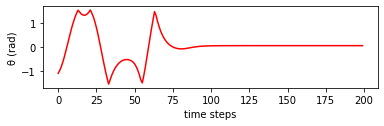

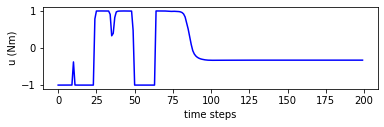

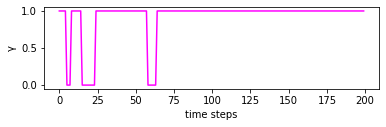

Episode 2: reward: -505.212, steps: 200


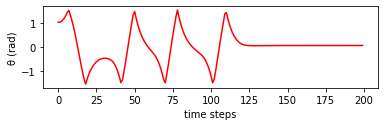

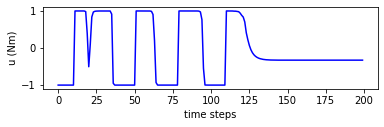

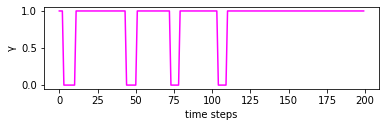

Episode 3: reward: -122.581, steps: 200


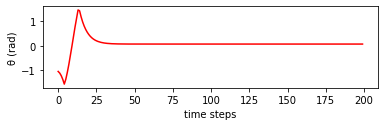

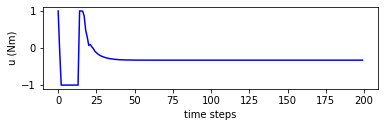

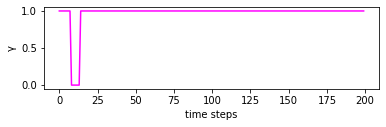

Episode 4: reward: -246.704, steps: 200


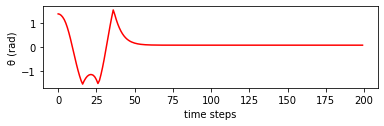

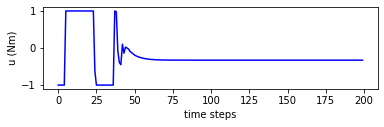

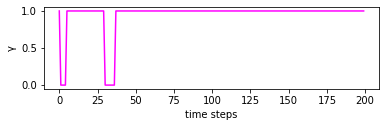

Episode 5: reward: -365.163, steps: 200


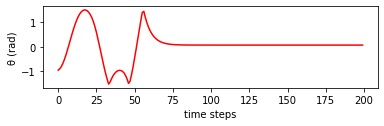

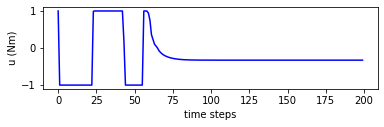

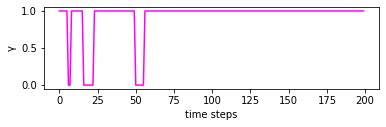

In [11]:
#agent.fit(env, lam=l, nb_steps=50000, visualize=True, verbose=1, nb_max_episode_steps=200)
print('Finish Learning. We start test phase.')
agent.test(env, lam=l, nb_episodes=5, visualize=0, nb_max_episode_steps=200, graph=True,action_view=0)

In [16]:
agent.save_weights('0.2free_model.h5')

$\lambda = 1$だと15万ステップ学習してもダメ

$\lambda = 0.1$だと1万5千くらいから立ち始める。その時はたってからは毎回通信。

In [6]:
for i in range(11):
    l = i*0.2
    def agent(a_shape, s_shape):
        actor = actor_net(a_shape, s_shape)
        critic,  critic_action_input = critic_net(a_shape, s_shape)
        memory = SequentialMemory(limit = 50000, window_length = 1)
        agent = eventDDPGAgent(
            a_shape[0],
            actor,
            critic,
            critic_action_input,
            memory
        )
        return agent

    a = agent((3,), env.observation_space.shape)
    a.compile(Adam(lr=0.001, clipnorm=1.), metrics=["mae"])
    a.fit(env, lam=l, nb_steps=50000, visualize=1, verbose=1, nb_max_episode_steps=200)
    a.save_weights(f'learned_models/normal{l}.h5')

Training for 50000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 152s 15ms/step - reward: -7.6021
50 episodes - episode_reward: -1520.418 [-1848.082, -926.173] - loss: 3.034 - mean_absolute_error: 0.515 - mean_q: -32.362

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 167s 17ms/step - reward: -6.1389
50 episodes - episode_reward: -1227.779 [-1853.759, -752.904] - loss: 19.983 - mean_absolute_error: 1.015 - mean_q: -85.907

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 168s 17ms/step - reward: -4.3081
50 episodes - episode_reward: -861.618 [-1656.482, -226.366] - loss: 39.277 - mean_absolute_error: 1.756 - mean_q: -112.669

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 167s 17ms/step - reward: -3.9846
50 episodes - episode_reward: -796.920 [-1477.454, -451.134] - loss: 53.780 - mean_absolute_error: 2.436 - mean_q: -125.479

Interval 5 (4000

Training for 50000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 63s 6ms/step - reward: -3.7850
50 episodes - episode_reward: -757.008 [-1091.840, -509.654] - loss: 27.167 - mean_squared_error: 54.334 - mean_q: 9.421

Interval 2 (10000 steps performed)
 5718/10000 [================>.............] - ETA: 29s - reward: -4.4135done, took 101.668 seconds


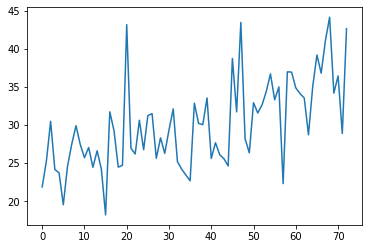

In [23]:
agent.fit(env, lam=l, nb_steps=50000, visualize=0, verbose=1, nb_max_episode_steps=200, loss_graph=1)

Training for 150000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 60s 6ms/step - reward: -1.5935
50 episodes - episode_reward: -318.692 [-727.146, -1.055] - loss: 30.884 - mean_squared_error: 61.767 - mean_q: -66.899

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 63s 6ms/step - reward: -1.6722
50 episodes - episode_reward: -334.447 [-644.433, -0.792] - loss: 22.827 - mean_squared_error: 45.653 - mean_q: -39.455

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 64s 6ms/step - reward: -2.0309
50 episodes - episode_reward: -406.185 [-1731.487, -0.861] - loss: 20.777 - mean_squared_error: 41.554 - mean_q: -27.843

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 64s 6ms/step - reward: -2.3320
50 episodes - episode_reward: -466.399 [-1734.120, -1.240] - loss: 19.490 - mean_squared_error: 38.980 - mean_q: -20.356

Interval 5 (40000 steps performed)
1

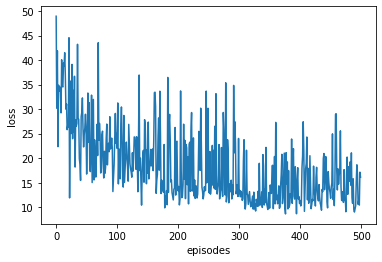

In [12]:
agent.fit(env, lam=l, nb_steps=150000, visualize=0, verbose=1, nb_max_episode_steps=200, loss_graph=1)

Testing for 5 episodes ...
Episode 1: reward: -123.812, steps: 200


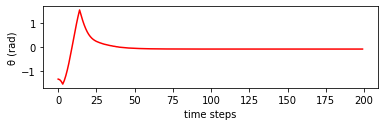

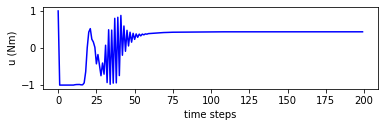

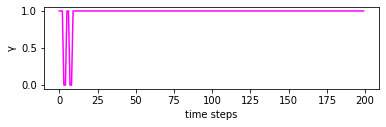

Episode 2: reward: -1730.688, steps: 200


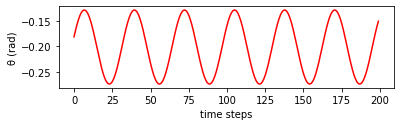

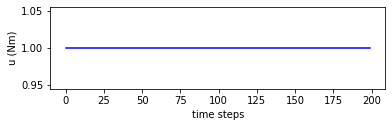

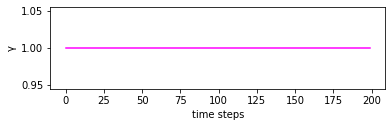

Episode 3: reward: -610.620, steps: 200


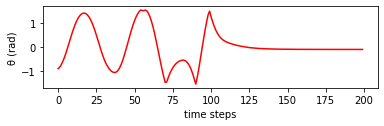

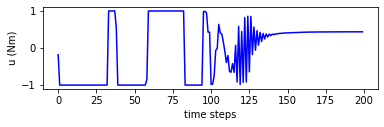

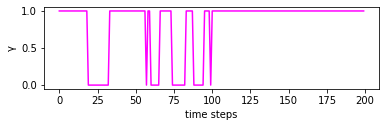

Episode 4: reward: -244.529, steps: 200


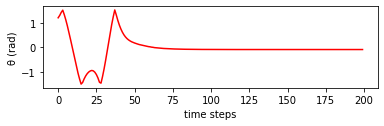

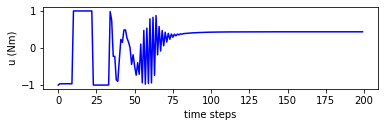

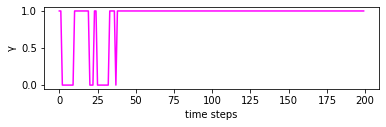

Episode 5: reward: -126.302, steps: 200


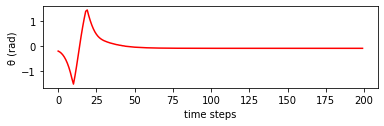

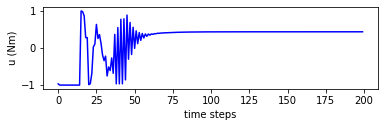

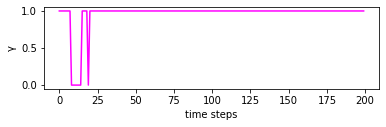

In [13]:
agent.test(env, lam=l, nb_episodes=5, visualize=0, nb_max_episode_steps=200, graph=True,action_view=0)